In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix


# Лабораторная работа 2.
«Наивный байесовский» классификатор.
## Задание.
1. Загрузить таблицу Mushroom из репозитория UCI (любого источника) в объект DataFrame.
Вычислить распределение значений категориальных признаков по классам (использовать pd.groupby).
Визуализировать распределения.
2. Построить решающую функцию по каждой переменной на основе частот. Вычислить точность каждого решения (на той же обучающей выборке). Найти наиболее информативную переменную (с минимальным числом ошибок).
3. Построить «наивный» байесовский классификатор из sklearn. Оценить точность. 
4. Самостоятельно реализовать метод, не используя готовый. Сравнить полученное решение с библиотечным. Добавить регуляризатор в оценки частот.
5. Применить метод логистической регрессии, использовав в качестве переменных оценки вероятностей, подвергнутые обратному логистическому преобразованию.


In [2]:
headers = [
    "class",                     # Класс (съедобный: 'e', ядовитый: 'p')
    "cap-shape",                 # Форма шляпки (bell: 'b', conical: 'c', convex: 'x', flat: 'f', knobbed: 'k', sunken: 's')
    "cap-surface",               # Поверхность шляпки (fibrous: 'f', grooves: 'g', scaly: 'y', smooth: 's')
    "cap-color",                 # Цвет шляпки
    "bruises",                   # Пятна (есть: 't', нет: 'f')
    "odor",                      # Запах
    "gill-attachment",           # Соединение жабер с ножкой (attached: 'a', descending: 'd', free: 'f', notched: 'n')
    "gill-spacing",              # Расстояние между жабрами (close: 'c', crowded: 'w', distant: 'd')
    "gill-size",                 # Размер жабер (broad: 'b', narrow: 'n')
    "gill-color",                # Цвет жабер
    "stalk-shape",               # Форма ножки (enlarging: 'e', tapering: 't')
    "stalk-root",                # Корень ножки (bulbous: 'b', club: 'c', cup: 'u', equal: 'e', rhizomorphs: 'z', rooted: 'r', missing: '?')
    "stalk-surface-above-ring",  # Поверхность ножки выше кольца (fibrous: 'f', scaly: 'y', silky: 'k', smooth: 's')
    "stalk-surface-below-ring",  # Поверхность ножки ниже кольца (fibrous: 'f', scaly: 'y', silky: 'k', smooth: 's')
    "stalk-color-above-ring",    # Цвет ножки выше кольца
    "stalk-color-below-ring",    # Цвет ножки ниже кольца
    "veil-type",                 # Тип вуали (partial: 'p', universal: 'u')
    "veil-color",                # Цвет вуали
    "ring-number",               # Количество колец (none: 'n', one: 'o', two: 't')
    "ring-type",                 # Тип кольца (cobwebby: 'c', evanescent: 'e', flaring: 'f', large: 'l', none: 'n', pendant: 'p', sheathing: 's', zone: 'z')
    "spore-print-color",         # Цвет спорового порошка
    "population",                # Популяция
    "habitat"                    # Среда обитания
]

# p, x, s, n, t, p.1, f, c, n.1, k, e, e.1, s.1, s.2, w, w.1, p.2, w.2, o, p.3, k.1, s.3, u

In [3]:
def get_metrix(conf_matrix):
    TN = conf_matrix[0, 0]  # TN
    FP = conf_matrix[0, 1]  # FP
    FN = conf_matrix[1, 0]  # FN
    TP = conf_matrix[1, 1]  # TP

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)

    accuracy = (TP + TN) / (TP + FP + TN + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    print("Precision:", f"{precision:.3f}") # оценивает, насколько предсказания положительного класса модели являются точными и не содержат ложных положительных предсказаний.
    print("Recall:", f"{recall:.3f}") # оценивает, насколько много положительных случаев модель способна обнаруживать и не упускать.
    print("Specificity:", f"{specificity:.3f}") # измеряет способность модели правильно классифицировать негативные образцы
    # print("-------------------")
    print("Accuracy:", f"{accuracy:.3f}") # показывает долю правильных предсказаний относительно общего числа предсказаний
    print("F1 Score:", f"{f1:.3f}")
    print("\n\n")

# Задание 1
Загрузить таблицу Mushroom из репозитория UCI (любого источника) в объект DataFrame.
Вычислить распределение значений категориальных признаков по классам (использовать pd.groupby).
Визуализировать распределения.


In [4]:
# df = pd.read_csv('./mushroom_data.csv')
# print(df.iloc[:0,:])

# Загрузка данных в DataFrame
df = pd.read_csv('./mushroom_data.csv', header=None)

# # Назначение имени столбцам
df.columns = headers
df.count()

class                       8124
cap-shape                   8124
cap-surface                 8124
cap-color                   8124
bruises                     8124
odor                        8124
gill-attachment             8124
gill-spacing                8124
gill-size                   8124
gill-color                  8124
stalk-shape                 8124
stalk-root                  8124
stalk-surface-above-ring    8124
stalk-surface-below-ring    8124
stalk-color-above-ring      8124
stalk-color-below-ring      8124
veil-type                   8124
veil-color                  8124
ring-number                 8124
ring-type                   8124
spore-print-color           8124
population                  8124
habitat                     8124
dtype: int64

In [5]:
# Извлечение категориальных столбцов
categorical_columns = df.select_dtypes(include=['object']).columns
print(categorical_columns)

# Инициализация пустого DataFrame для хранения распределения
distribution_by_class = pd.DataFrame(columns=['class'])

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')


Распределение значений категориальных признаков по классам представляет собой информацию о том, какие значения категориальных признаков встречаются в различных классах (группах) данных. Это позволяет понять, какие значения категориальных признаков характерны для каждого класса, и может быть полезно при анализе и прогнозировании данных.

простыми словами помагает нам понять какие признаки  важны для програзирования и какие могут быть информативными для решения задач классификации

  class     e     p    b  c     f    k   s     x     f  ...    s     v     y  \
e   NaN  4208     0  404  0  1596  228  32  1948  1560  ...  880  1192  1064   
p   NaN     0  3916   48  4  1556  600   0  1708   760  ...  368  2848   648   

      d     g    l    m     p    u    w  
e  1880  1408  240  256   136   96  192  
p  1268   740  592   36  1008  272    0  

[2 rows x 120 columns]


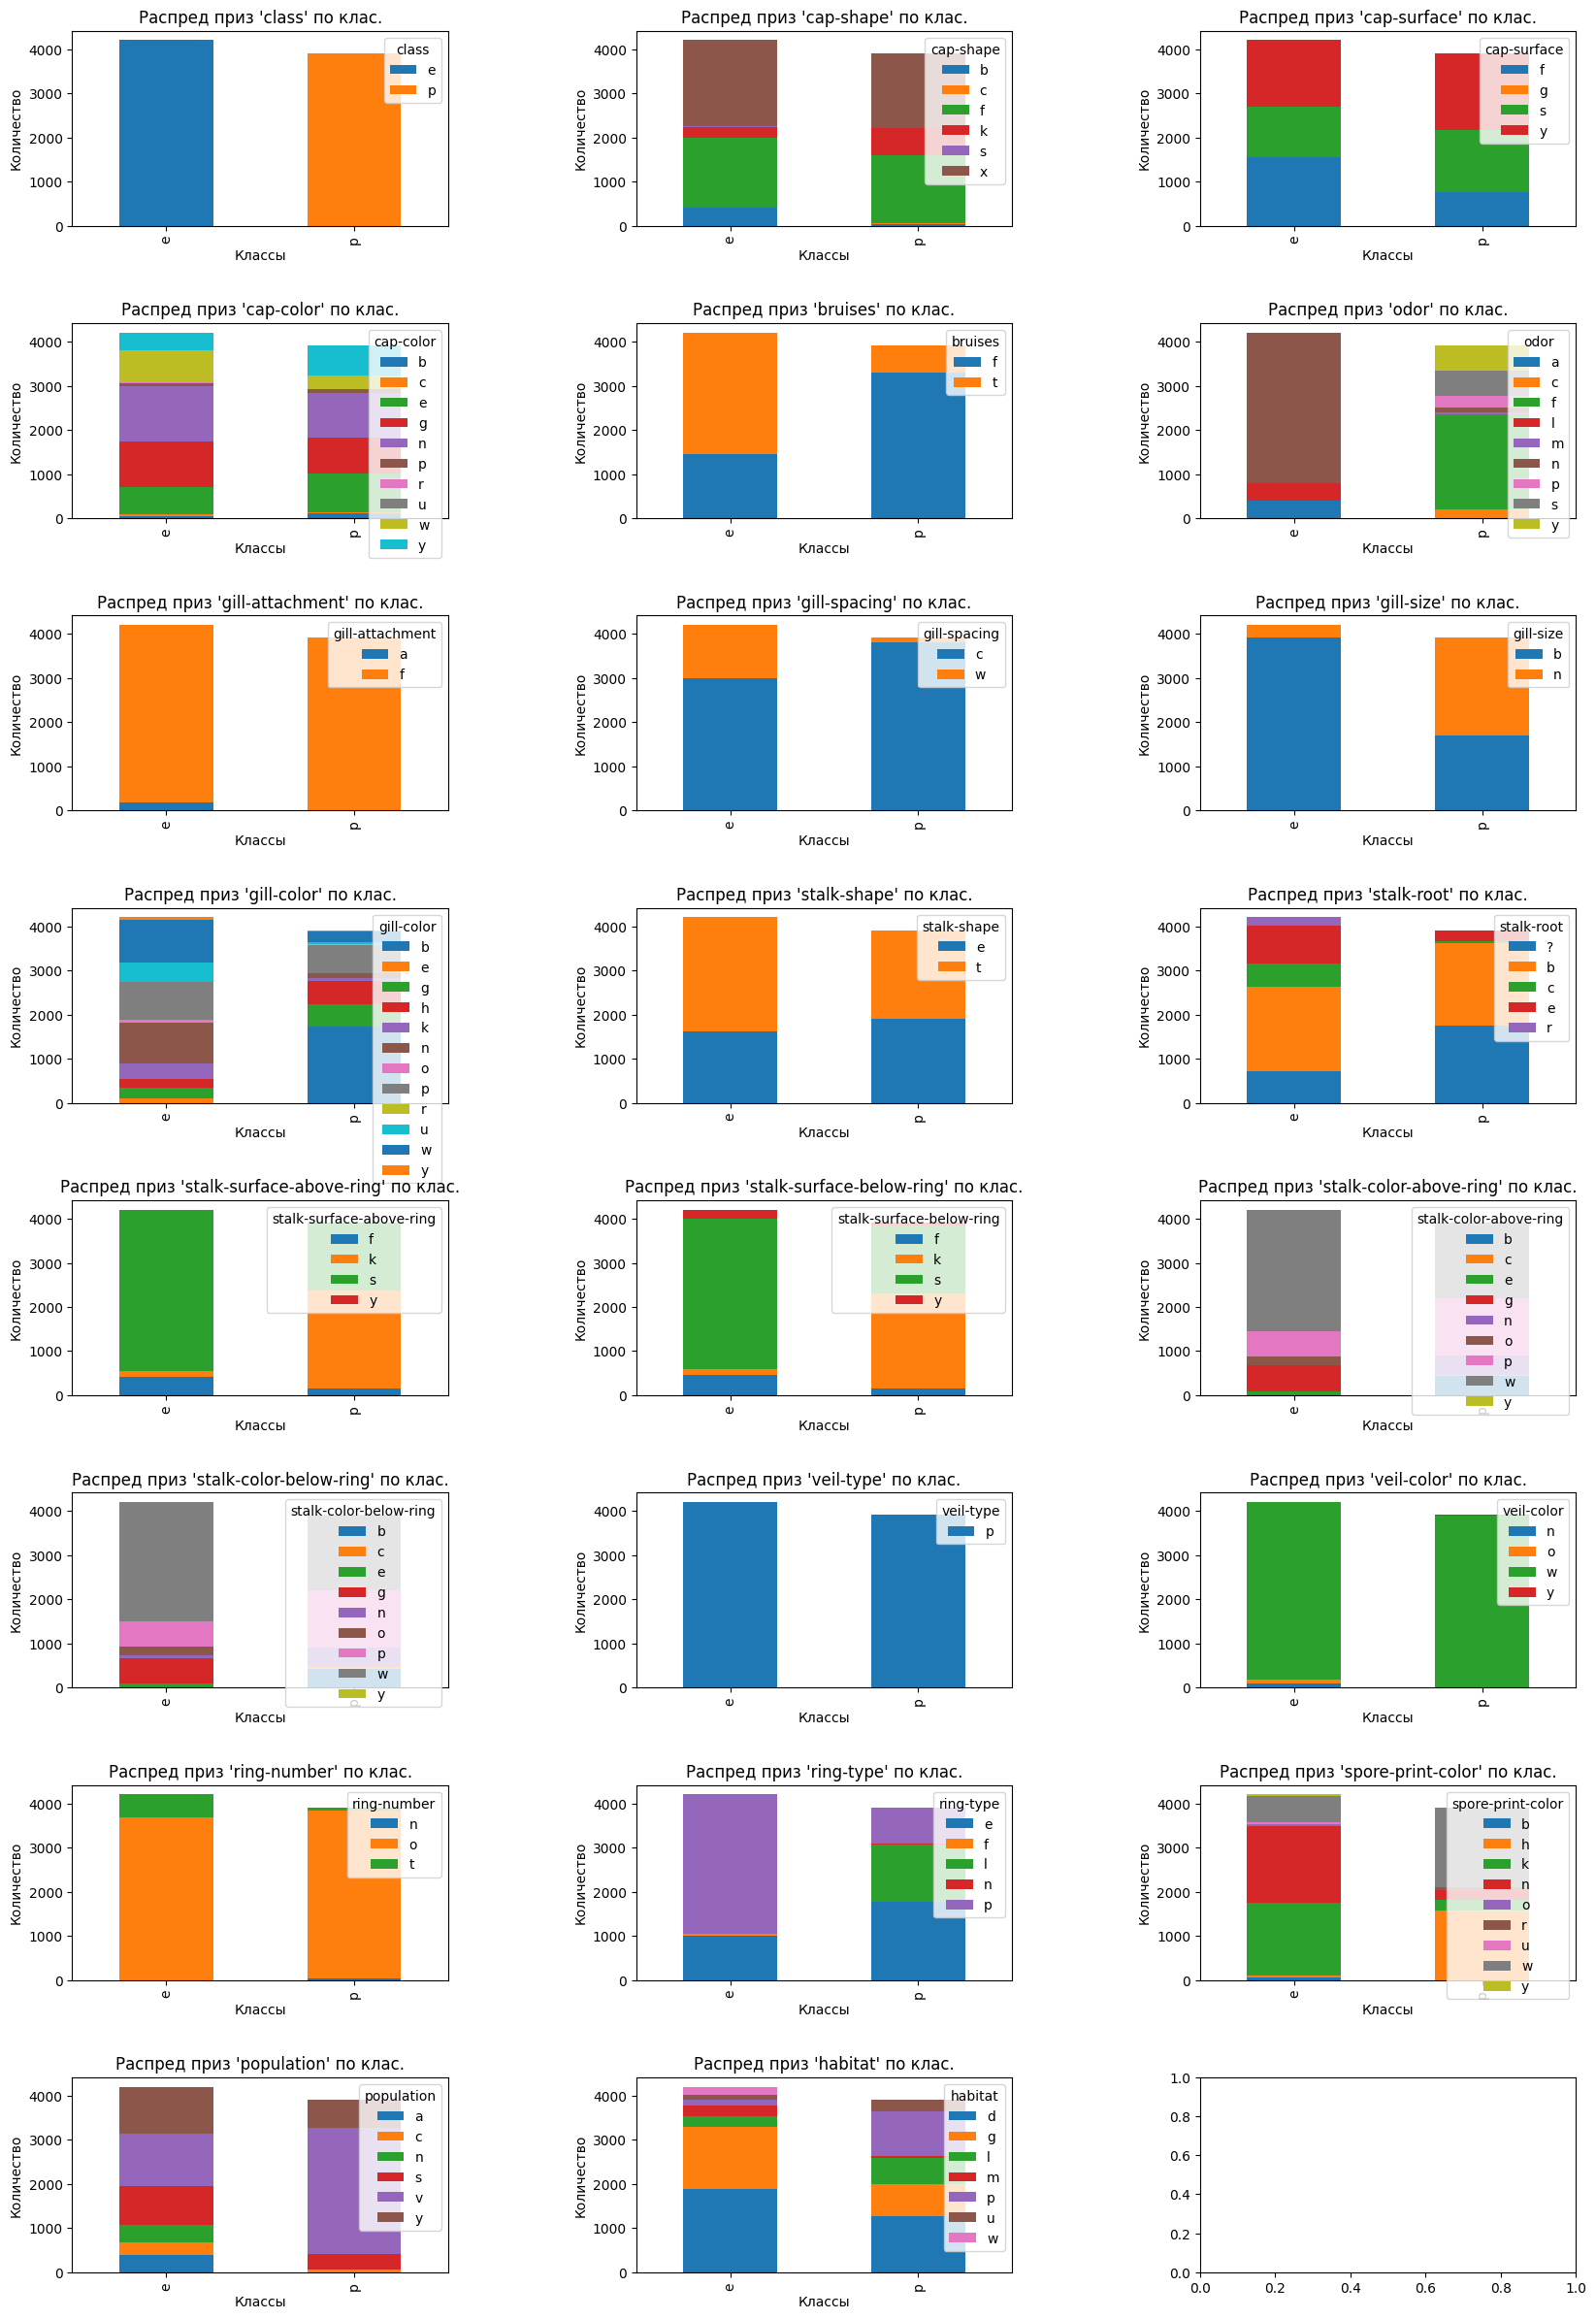

In [6]:
num_columns = 3
num_rows = math.ceil(len(headers) / num_columns)

# Создайте сетку графиков
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 30))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

i = 0

# Вычисление распределения для каждого категориального столбца
for feature  in categorical_columns:
    row = i // num_columns
    col = i % num_columns
    
    distribution = df.groupby(['class', feature]).size().unstack(fill_value=0)
    distribution_by_class = pd.concat([distribution_by_class, distribution], axis=1)

    distribution.plot(kind='bar', stacked=True, ax=axes[row, col])
    axes[row, col].set_title(f"Распред приз '{feature}' по клас.")
    axes[row, col].set_xlabel("Классы")
    axes[row, col].set_ylabel("Количество")
    axes[row, col].legend(title=feature, loc='upper right')

    i = i + 1

# Вывод распределения
print(distribution_by_class)

# Задание 2
### Построить решающую функцию по каждой переменной на основе частот. Вычислить точность каждого решения (на той же обучающей выборке). Найти наиболее информативную переменную (с минимальным числом ошибок).


Решающая функция - функцией, которая принимает на вход набор признаков объекта и возвращает предсказание относительно его принадлежности к одному из классов. Решающая функция определяет, какой класс будет назначен объекту на основе его признаков.

In [7]:
# Преобразование категориальных признаков в числа
le = LabelEncoder()
for col in df.columns:
    if col != 'class':
        df[col] = le.fit_transform(df[col])

# df.iloc[:5,:]

X = df.drop('class', axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Решающая функция
def decision_function(x):
    # Расчитываю чистоты
    counts = X_train[y_train == 'e'][col].value_counts()
    # встречается ли это значение в обучающем наборе
    return 'e' if x in counts.index and counts[x] > 0 else 'p'

# Построение решающей функции для каждого категориального признака и вычисление точности
accuracies = {}
most_info_variable = ""
most_acc = 0
for col in X_train.columns:
    # Примените решающую функцию к тестовой выборке
    y_pred = X_test[col].apply(decision_function)
    accuracy = accuracy_score(y_test, y_pred)

    accuracies[col] = accuracy
    if accuracy > most_acc:
        most_info_variable = col
        most_acc = accuracy

print("Точность решающей функции для каждой переменной (е):")
for col, accuracy in accuracies.items():
    print(f"{col}: ac - {accuracy:.4f} ")

print(f"\nНаиболее информативная переменная: {most_info_variable} {most_acc}")

Точность решающей функции для каждой переменной (е):
cap-shape: ac - 0.5194 
cap-surface: ac - 0.5194 
cap-color: ac - 0.5188 
bruises: ac - 0.5188 
odor: ac - 0.9846 
gill-attachment: ac - 0.5188 
gill-spacing: ac - 0.5188 
gill-size: ac - 0.5188 
gill-color: ac - 0.7255 
stalk-shape: ac - 0.5188 
stalk-root: ac - 0.5188 
stalk-surface-above-ring: ac - 0.5188 
stalk-surface-below-ring: ac - 0.5188 
stalk-color-above-ring: ac - 0.5754 
stalk-color-below-ring: ac - 0.5785 
veil-type: ac - 0.5188 
veil-color: ac - 0.5194 
ring-number: ac - 0.5218 
ring-type: ac - 0.6868 
spore-print-color: ac - 0.5274 
population: ac - 0.5188 
habitat: ac - 0.5188 

Наиболее информативная переменная: odor 0.9846153846153847


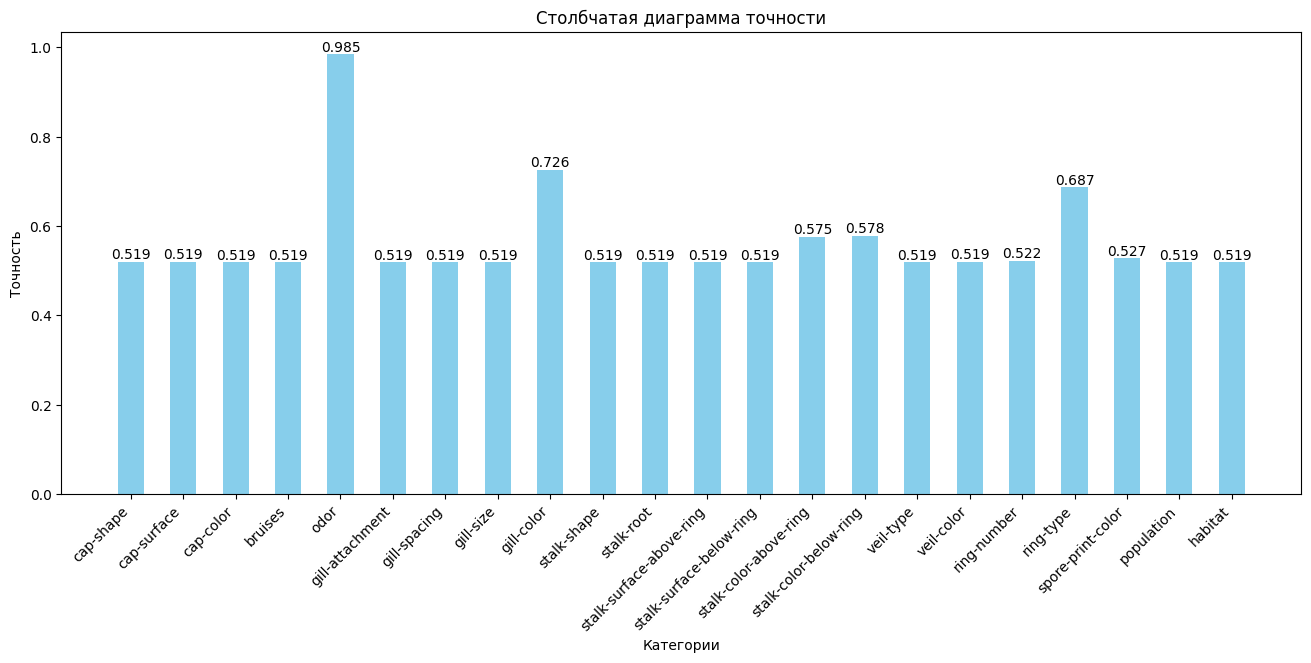

In [15]:
categories = list(accuracies.keys())
accuracy_values = list(accuracies.values())

# Создание столбчатой диаграммы с увеличенной шириной столбцов и расстоянием между ними
fig, ax = plt.subplots(figsize=(16, 6))
bar_width = 0.5  # Ширина столбцов
index = np.arange(len(categories))

plt.bar(index, accuracy_values, bar_width, color='skyblue')
plt.xlabel("Категории")
plt.ylabel("Точность")
plt.title("Столбчатая диаграмма точности")

# Опционально: добавление чисел над столбцами
for i, accuracy in enumerate(accuracy_values):
    plt.text(i, accuracy, f"{accuracy:.3f}", ha="center", va="bottom")

# Опционально: добавление заголовков с углом наклона
plt.xticks(index, categories, rotation=45, ha="right")

plt.show()

# Задание 3
## Построить «наивный» байесовский классификатор из sklearn. Оценить точность. 

Основан на теореме Байеса и считается "наивным", потому что делает упрощающее предположение о независимости признаков, что может быть не всегда справедливо в реальных данных. Его принцип

1 Собрание обучающего набора данных: Алгоритм требует обучающий набор данных, в котором для каждого объекта известны его признаки и соответствующий класс.

2 Вычисление априорных вероятностей классов: Для каждого класса вычисляются априорные вероятности P(Ci), то есть вероятности принадлежности объекта к каждому классу. Это можно сделать путем подсчета доли объектов, принадлежащих каждому классу, в обучающем наборе данных.

3 Вычисление условных вероятностей признаков для каждого класса: Для каждого признака вычисляются условные вероятности P(Xi|Ci), которые представляют собой вероятности того, что данный признак имеет конкретное значение, при условии, что объект принадлежит к классу Ci. Эти вероятности могут быть оценены на основе данных в обучающем наборе.

Применение теоремы Байеса: Для нового объекта с неизвестным классом вычисляются вероятности принадлежности к каждому классу на основе априорных вероятностей и условных вероятностей признаков. Это делается с использованием теоремы Байеса:

### P(Ci|X) = (P(X|Ci) * P(Ci)) / P(X)

Где:

 > P(Ci|X) - вероятность принадлежности к классу Ci при данном наблюдении X.

 > P(X|Ci) - условная вероятность наблюдения X при классе Ci (произведение условных вероятностей признаков).

 > P(Ci) - априорная вероятность класса Ci.
 
 > P(X) - общая вероятность наблюдения X (нормализующая константа).
Выбор класса: Алгоритм выбирает класс с наибольшей вероятностью, то есть класс, для которого P(Ci|X) максимальна.

Наивный байесовский классификатор обладает несколькими преимуществами:

Он эффективен и быстр в обучении и предсказаниях.
Может работать с большими объемами данных.
Хорошо справляется с текстовыми данными и задачами классификации текста.
Несмотря на свою наивность, он может давать хорошие результаты, особенно когда выполняются предположения о независимости признаков, и является хорошим выбором для начальной модели в задачах классификации.

---

"Получите бесплатное предложение!"
"Специальное предложение только сегодня!"
"Срочное сообщение от банка"
"Привет, как дела?"


1 Вычисление априорных вероятностей: 
P(Spam) = 2/4 = 0.5 (половина сообщений в обучающем наборе - спам)
P(Not Spam) = 2/4 = 0.5 (половина сообщений - не спам)

2 Вычисление условных вероятностей для каждого слова:
P("Получите" | Spam) = 1/2 = 0.5 (слово "Получите" встречается в 1 из 2 спам-сообщений)
P("бесплатное" | Spam) = 1/2 = 0.5
P("предложение" | Spam) = 2/2 = 1.0 (слово "предложение" встречается во всех спам-сообщениях)
P("Специальное" | Spam) = 1/2 = 0.5
P("только" | Spam) = 1/2 = 0.5
P("сегодня" | Spam) = 1/2 = 0.5
и так далее для всех слов

3 Вычисление условных вероятностей для каждого слова при неспаме:
P("Срочное" | Not Spam) = 0/2 = 0.0 (слово "Срочное" не встречается в неспам-сообщениях)
P("сообщение" | Not Spam) = 0/2 = 0.0
P("от" | Not Spam) = 0/2 = 0.0
P("банка" | Not Spam) = 1/2 = 0.5 (слово "банка" встречается в 1 из 2 неспам-сообщений)
P("Привет" | Not Spam) = 1/2 = 0.5
P("как" | Not Spam) = 1/2 = 0.5
P("дела" | Not Spam) = 1/2 = 0.5
и так далее для всех слов

4 Предсказание:
Теперь, если у нас есть новое сообщение, например, "Специальное предложение для вас!", мы можем вычислить вероятности для каждого класса и выбрать тот класс, который имеет наибольшую вероятность. Для этого сообщения:

P(Spam|Message) = P(Spam) * P("Специальное"|Spam) * P("предложение"|Spam) * P("для"|Spam) * P("вас!"|Spam)

P(Not Spam|Message) = P(Not Spam) * P("Специальное"|Not Spam) * P("предложение"|Not Spam) * P("для"|Not Spam) * P("вас!"|Not Spam)

Мы выбираем класс с наибольшей вероятностью (в данном случае, Spam), и сообщение классифицируется как "Спам".

In [20]:
from sklearn.naive_bayes import GaussianNB
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
get_metrix(conf_matrix)

Precision: 0.910
Recall: 0.930
Specificity: 0.915
Accuracy: 0.922
F1 Score: 0.920





c:\Users\emely\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\emely\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\emely\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\emely\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning:

# Задание 4
Самостоятельно реализовать метод, не используя готовый. Сравнить полученное решение с библиотечным. Добавить регуляризатор в оценки частот.

Наивный байесовский классификатор предполагает, что признаки X1 и X2 независимы 

Альфа-регуляризатор, также известный как Лапласово сглаживание 
Проблема нулевых вероятностей: Если в обучающем наборе отсутствуют некоторые комбинации признаков, то вероятности этих комбинаций будут равны нулю. 
Это создает проблему при расчете условных вероятностей и может привести к тому, что классификатор будет неспособен обрабатывать новые данные, содержащие такие комбинации признаков.

Проблема переобучения: Без сглаживания, "наивный" байесовский классификатор может сильно доверять обучающим данным и давать высокие вероятности для наблюдений, которые он никогда не видел ранее. 
Это может привести к переобучению, когда классификатор становится чрезмерно уверенным в своих прогнозах.


Альфа-регуляризатор решает эти проблемы, добавляя маленькое значение (α, alpha) к числителю и знаменателю при вычислении вероятностей. Это позволяет избежать нулевых вероятностей и сглаживает вероятности, делая их менее экстремальными. В результате классификатор становится менее чувствительным к выборкам и более устойчивым.

Тем не менее, важно правильно настраивать параметр α. Если α слишком мал, сглаживание будет недостаточным, и классификатор будет чрезмерно доверять данным. Если α слишком большой, это может привести к слишком сильному сглаживанию, и классификатор может упустить важные различия между классами. Настройка α обычно выполняется на валидационных данных или с использованием методов кросс-валидации.

In [21]:
class NaiveBayesClassifier:
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # аддитивное сглаживание
        self.class_aprior = {}  # априорных вероятности
        self.feature_yslov = {}  # условные вероятности

    def fit(self, X, y):
        amount, _ = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Вычисление априорных вероятностей классов
        for c in self.classes:
            self.class_aprior[c] = (
                np.sum(y == c) + self.alpha) / (amount + n_classes * self.alpha)

        # Вычисление условных вероятностей признаков
        for c in self.classes:
            self.feature_yslov[c] = {}

            for feature in X.columns:
                feature_counts = X[y == c][feature].value_counts() # распределение значений признака в классе

                # print(X[y == c][feature].value_counts())

                total_in_class = np.sum(y == c) # Общее количество примеров в классе
                # Расчет условных вероятностей с учетом сглаживания
                self.feature_yslov[c][feature] = (
                    feature_counts + self.alpha) / (total_in_class + len(feature_counts) * self.alpha)
        

    def predict(self, X):
        predictions = []

        # ходим по строкам
        for _, row in X.iterrows():
            class_scores = {}
            for c in self.classes:
                # Логарифм априорной вероятности класса
                class_scores[c] = np.log(self.class_aprior[c])
                for feature, value in row.items():
                    if value in self.feature_yslov[c][feature]:
                        # Если значение признака присутствует в условных вероятностях, добавляем логарифм
                        class_scores[c] += np.log(
                            self.feature_yslov[c][feature][value])
                    else:
                        # Используем сглаживание для недостающих значений признака
                        class_scores[c] += np.log(self.alpha / (np.sum(X.columns == feature) + len(
                            self.feature_yslov[c]) * self.alpha))
            # Выбор класса с максимальной оценкой
            predictions.append(max(class_scores, key=class_scores.get))
            
        return predictions

In [ ]:
# Создайте и обучите наивный байесовский классификатор
nb_classifier_my = NaiveBayesClassifier(alpha=1.0)
nb_classifier_my.fit(X_train, y_train)

# Сделайте прогнозы на тестовом наборе
y_pred = nb_classifier_my.predict(X_test)

print("библиотека")
get_metrix(conf_matrix)

print("моя")
conf_matrix = confusion_matrix(y_test, y_pred)
get_metrix(conf_matrix)

библиотека
Precision: 0.910
Recall: 0.930
Specificity: 0.915
Accuracy: 0.922
F1 Score: 0.920



моя
Precision: 0.976
Recall: 0.826
Specificity: 0.981
Accuracy: 0.906
F1 Score: 0.895





# Задание 5
Применить метод логистической регрессии, использовав в качестве переменных оценки вероятностей, подвергнутые обратному логистическому преобразованию.

In [22]:
mushroom_df = pd.read_csv("mushroom_data.csv")
mushroom_df.columns = headers
features = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

df_ = pd.read_csv("mushroom_data.csv", header=None).drop(0, axis=0)
df = pd.DataFrame()

result_data = {}
most_info_variable = ""
most_acc = 0

for idx, feature in enumerate(features, 1):
    value_counts = df_.groupby(idx)[0].value_counts().unstack()
    probabilities = value_counts['p'] / (value_counts['p'] + value_counts['e'])

    Probability = mushroom_df[feature].map(probabilities)
    Logit = np.log(Probability / (1 - Probability))
    After_Sigmoid = 1 / (1 + np.exp(-Logit))
    
    accuracy = accuracy_score(mushroom_df['class'], After_Sigmoid.apply(lambda x: 'e' if x <= 0.5 else 'p'))
    result_data[feature] = accuracy

    if accuracy > most_acc:
        most_info_variable = col
        most_acc = accuracy

print("Точность решающей функции для каждой переменной (е):")
for col, accuracy in result_data.items():
    print(f"{col}: {accuracy:.4f}")

print(f"\nНаиболее информативная переменная: {most_info_variable} {most_acc}")

Точность решающей функции для каждой переменной (е):
cap-shape: 0.5604
cap-surface: 0.5805
cap-color: 0.5914
bruises: 0.7441
odor: 0.8867
gill-attachment: 0.5180
gill-spacing: 0.6159
gill-size: 0.7562
gill-color: 0.7854
stalk-shape: 0.5529
stalk-root: 0.6224
stalk-surface-above-ring: 0.7746
stalk-surface-below-ring: 0.7662
stalk-color-above-ring: 0.6101
stalk-color-below-ring: 0.6081
veil-type: 0.5180
veil-color: 0.4954
ring-number: 0.5381
ring-type: 0.7697
spore-print-color: 0.8445
population: 0.6254
habitat: 0.6666

Наиболее информативная переменная: habitat 0.8867413517173458


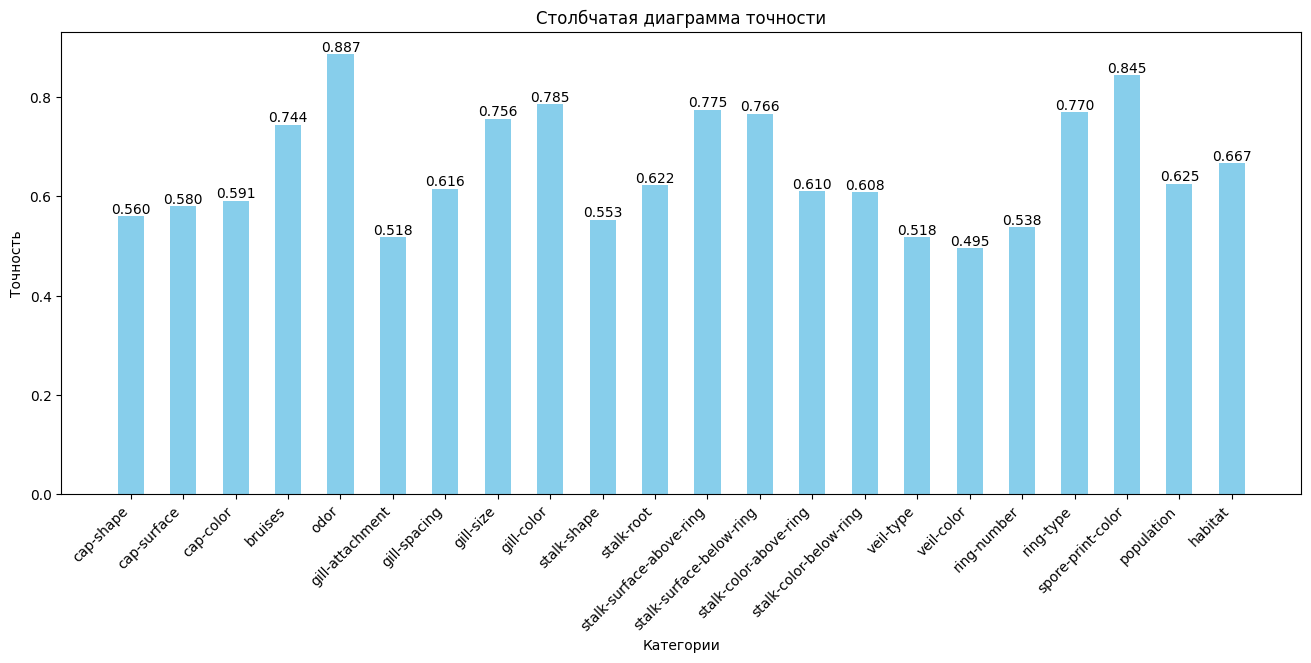

In [23]:
categories = list(result_data.keys())
accuracy_values = list(result_data.values())

fig, ax = plt.subplots(figsize=(16, 6))
bar_width = 0.5  # Ширина столбцов
index = np.arange(len(categories))

plt.bar(index, accuracy_values, bar_width, color='skyblue')
plt.xlabel("Категории")
plt.ylabel("Точность")
plt.title("Столбчатая диаграмма точности")

# Опционально: добавление чисел над столбцами
for i, accuracy in enumerate(accuracy_values):
    plt.text(i, accuracy, f"{accuracy:.3f}", ha="center", va="bottom")

# Опционально: добавление заголовков с углом наклона
plt.xticks(index, categories, rotation=45, ha="right")

plt.show()

# мусор

In [ ]:
categories = list(accuracies.keys())
accuracy_values = list(accuracies.values())

# Создание столбчатой диаграммы с увеличенной шириной столбцов и расстоянием между ними
fig, ax = plt.subplots(figsize=(16, 6))
bar_width = 0.5  # Ширина столбцов
index = np.arange(len(categories))

plt.bar(index, accuracy_values, bar_width, color='skyblue')
plt.xlabel("Категории")
plt.ylabel("Точность")
plt.title("Столбчатая диаграмма точности")

# Опционально: добавление чисел над столбцами
for i, accuracy in enumerate(accuracy_values):
    plt.text(i, accuracy, f"{accuracy:.3f}", ha="center", va="bottom")

# Опционально: добавление заголовков с углом наклона
plt.xticks(index, categories, rotation=45, ha="right")

plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)
y_pred_nb_classifier = nb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Точность MultinomialNB: {:.2f}%".format(accuracy * 1))

# Получим оценки вероятностей принадлежности к классам
# содержит оценки вероятностей для каждого образца
probabilities = model_nb.predict_proba(X_test)[:, 1]
# Применим обратное логистическое преобразование
log_odds = np.log(probabilities / (1 - probabilities))

model_lr = LogisticRegression()
model_lr.fit(log_odds.reshape(-1, 1), y_test)
y_pred = model_lr.predict(log_odds.reshape(-1, 1))

accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели LogisticRegression: {accuracy:.2f}\n\n")

Точность MultinomialNB: 0.91%
Точность модели LogisticRegression: 0.82




c:\Users\emely\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\emely\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\emely\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\emely\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: